## 3- Evaluating a pre-trained model

In the last notebook, we show how to evaluate pre-trained models that can be found in the ``data/model`` directory. We will look at the two models used in the paper which are:

* A simple CNN
* A model which embeds physical constraints (SGTNN)

In [1]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

sys.path.append('../src')

from dataset import *
from evals import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



### Importing testing data

Here we import the testing data in developed turbulence regime with the algebraic models results. Note that it is also possible to load samples prior to that, which corresponds to the transitional regime. A scalar decay configuration is also available in the dataset and can be loaded and evaluated in the same way. 

In [3]:
data_path = '../data/subgrid-scalar-dataset/'

tests_dataset = SubgridDataset(
    device=device,
    path=data_path + 'tests/08/', 
    samples=120,
    established=40,
    size=64,
    x=['velocity_field_x_nd_08', 'velocity_field_y_nd_08', 'velocity_field_z_nd_08', 'scalar_field_nd_08'],
    y=['sgs_flux_div_dns_nd_08', 
       'sgs_flux_div_dynsmag_nd_08', 
       'sgs_flux_div_dynrg_nd_08'
      ]
)

### Loading pre-trained models

We load the two pre-trained models and run the evaluation with the helper function provided in ``evals.py``. The metrics considered are the same from the paper:

* Mean-Squared-Error ($\mathcal{L}_{2}$)
* Cross-Correlation ($\mathcal{P}$) 
* Integral Dissipation ($\mathcal{I}$)
* Jensen Shannon distance ($\mathcal{J}$)
* Kolmogorov-Smirnov statistic ($\mathcal{K}$)

The evaluation function also shows the closure term along with its absolute error from the DNS and some statistic plots about the PDF, CDF and quantiles. 

		 MSE (L2) 		 Dissipation error (I) 	 Cross-correlation (P)

    	 Smag  	 1.8531410694122314 	 0.17674796283245087 	 0.36022394556649695

    	 Rg    	 1.6048167943954468 	 0.06243924796581268 	 0.49685855948680907

	CNN 	 1.599644660949707 	 0.10205487906932831 	 0.5596786392808897

	SGTNN 	 1.4642767906188965 	 0.11903373897075653 	 0.6118057176429389

		 JS distance (J) 	 KS test (K)

    	 Smag  	 0.28401040506153347 	 0.17424049377441408

    	 Rg    	 0.34714069515810536 	 0.21368560791015634

	CNN 	 0.08675181021199081 	 0.05537748336791992

	SGTNN 	 0.10703155207678153 	 0.06898307800292969



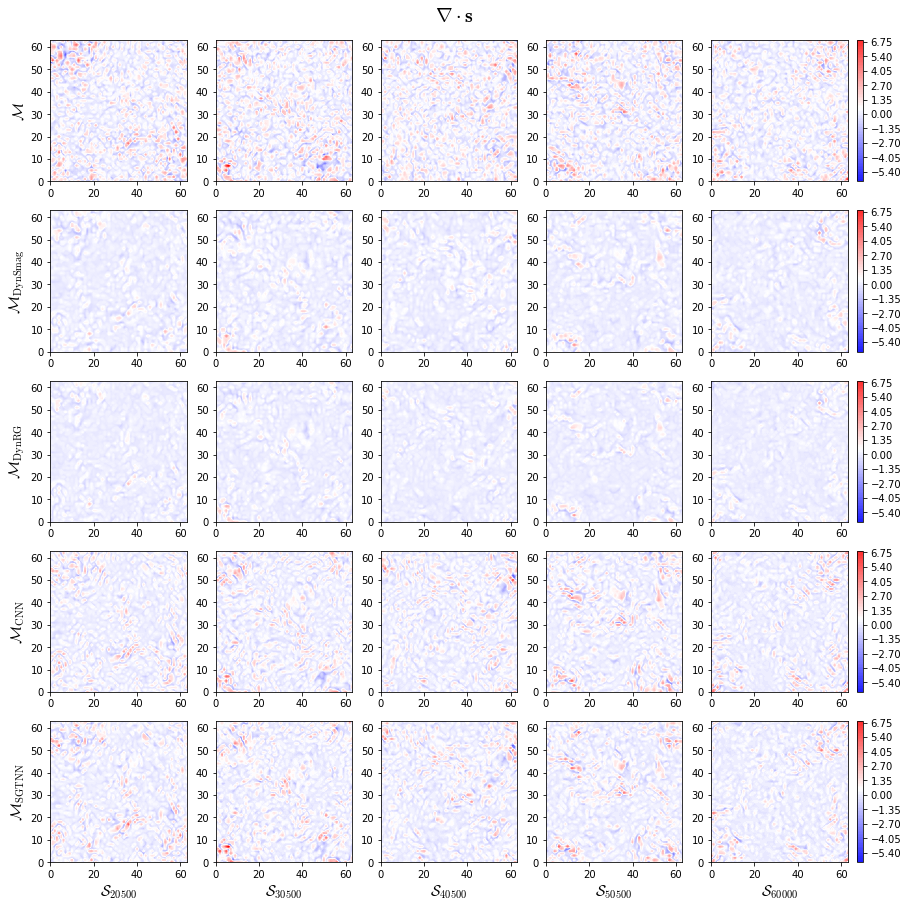

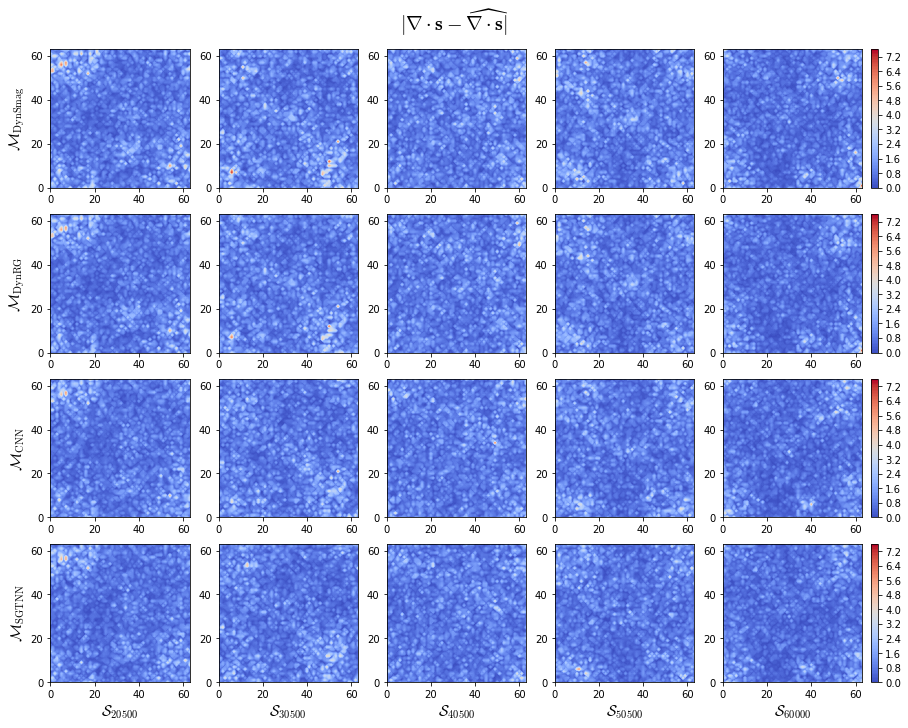

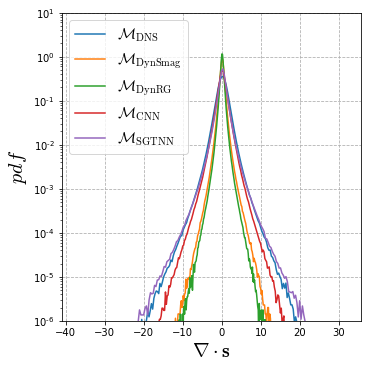

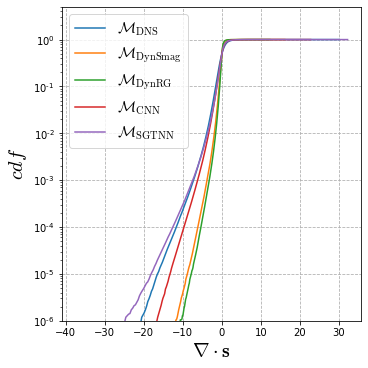

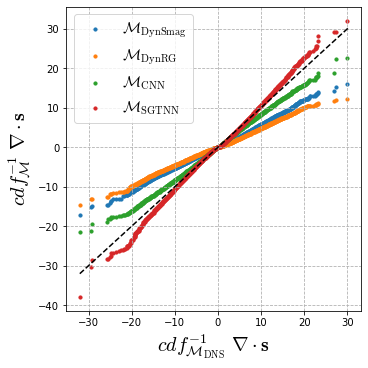

In [4]:
from blocks.CNN import ConvUnit, UnitaryUnit, BlockCNN

layers=[
    ConvUnit(in_size= 4, out_size=  8, kernel=3), 
    ConvUnit(in_size= 8, out_size= 16, kernel=3), 
    ConvUnit(in_size=16, out_size= 32, kernel=3), 
    ConvUnit(in_size=32, out_size= 64, kernel=3), 
    ConvUnit(in_size=64, out_size=128, kernel=3), 
    UnitaryUnit(in_size=128)
]

CNN = BlockCNN(name='CNN', layers=layers).to(device)
CNN.load_state_dict(torch.load('../data/models/pretrained_CNN/weights.pyt'))
CNN.eval()

from blocks.SGTNN import SGTNN

SGTNN = SGTNN(name='SGTNN').to(device)
SGTNN.load_state_dict(torch.load('../data/models/pretrained_SGTNN/weights.pyt'))
SGTNN.eval()

# evaluate the models
evaluate(dataset=tests_dataset, models=[CNN, SGTNN])

### Evaluating physical properties

We can also test for some physical properties explained in the paper. The following code computes the MSE on uniformly sampled values of $\lambda$ and $\beta$ for the transport linearity and the galilean invariance.

In [5]:
import random

# transport linearity
lin_mse = {}
lin_mse['cnn'] = 0.0
lin_mse['sgt'] = 0.0

lin_mse_cnn = []
lin_mse_sgt = []

for i in range(0, 10):
  a = random.uniform(-1.0, 1.0)
  lin_mse_eval = evaluate_mse(alpha=a, beta=0.0, dataset=tests_dataset, models=[CNN, SGTNN])
    
  lin_mse_cnn.append(lin_mse_eval['CNN'  ].item())
  lin_mse_sgt.append(lin_mse_eval['SGTNN'].item())

  lin_mse['cnn'] += lin_mse_eval['CNN'  ]
  lin_mse['sgt'] += lin_mse_eval['SGTNN']

print('Transport linearity \t [MSE]\t CNN : {}\t  SGTNN : {}'.format(lin_mse['cnn'] / 10, lin_mse['sgt'] / 10))
print('Transport linearity \t [VAR]\t CNN : {}\t  SGTNN : {}'.format(np.var(lin_mse_cnn), np.var(lin_mse_sgt)))

# galilean invariance
gal_mse = {}
gal_mse['cnn'] = 0.0
gal_mse['sgt'] = 0.0

gal_mse_cnn = []
gal_mse_sgt = []

for i in range(0, 10):
  b = random.uniform(-1.0, 1.0)
  gal_mse_eval = evaluate_mse(alpha=1.0, beta=b, dataset=tests_dataset, models=[CNN, SGTNN])
    
  gal_mse_cnn.append(gal_mse_eval['CNN'  ].item())
  gal_mse_sgt.append(gal_mse_eval['SGTNN'].item())

  gal_mse['cnn'] += gal_mse_eval['CNN'  ]
  gal_mse['sgt'] += gal_mse_eval['SGTNN']

print('Galilean invariance \t [MSE]\t CNN : {}\t  SGTNN : {}'.format(gal_mse['cnn'] / 10, gal_mse['sgt'] / 10))
print('Galilean invariance \t [VAR]\t CNN : {}\t  SGTNN : {}'.format(np.var(gal_mse_cnn), np.var(gal_mse_sgt)))

Transport linearity 	 [MSE]	 CNN : 2.650369644165039	  SGTNN : 1.4642765522003174
Transport linearity 	 [VAR]	 CNN : 3.9093298042629803	  SGTNN : 0.0
Galilean invariance 	 [MSE]	 CNN : 1.9357852935791016	  SGTNN : 1.4642765522003174
Galilean invariance 	 [VAR]	 CNN : 0.019579052455270016	  SGTNN : 3.4106051316484808e-15
